# CatBoostClasiffier

In [37]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [2]:
# Cargar los datos
df = pd.read_csv("../../data/processed/data_simp_preprocess_v2.csv")

Extraemos las etiquetas, descartamos las variables que carecen de valor predictivo (`id`) y las que están representadas como dummies. 

In [3]:
df_label = df["label"].astype(int)
df_label

0       1
1       0
2       0
3       1
4       0
       ..
8945    1
8946    1
8947    0
8948    1
8949    0
Name: label, Length: 8950, dtype: int64

In [4]:
drop_cols = ["id", "statement", "subject", "party_affiliation", "speaker","party_affiliation_category_map"]

Para observar qué variables son éstas últimas, obtenemos las no binarias (booleans o numéricas con dos valores): 

In [5]:
# 1. Seleccionar columnas no booleanas ni binarias
non_binary_cols = []
non_binary_cols += df.select_dtypes(exclude=['bool', 'number']).columns.tolist()

# Columnas numéricas que tienen más de 2 valores únicos (excluyendo label)
non_binary_cols += [
    col for col in df.select_dtypes(include='number').columns
    if df[col].nunique() > 2 and col != 'label'
]
non_binary_cols

['id',
 'statement',
 'subject',
 'speaker',
 'party_affiliation',
 'party_affiliation_uni',
 'party_affiliation_category_map',
 'speaker_job_grouped']

## Ingeniería de Características

Se ha añadido desde el preprocesado la variable `speaker_job_grouped` con la intención de sumarizar el impacto de la variable speaker_job, reducir cardinalidad del modelo y eliminar los dummies. Además, se contemplan las siguientes variables:

### Información no definida

Observadas las variables dummies `state_info_non-define`y `speaker_job_non-define`, se pretende analizar si la presencia de información no definida o imprecisa puede suponer determinante para la detección de *fake news*. Para ello, se crea una nueva variable booleana `has_non_define_info`, que representa un `OR` sobre las variables anteriores. Por tanto, indica si una noticia contiene información poco definida, ambigua o no verificable (1) o no la contiene (0).

In [6]:
# Crear variable: 1 si el trabajo o estado del speaker está no definido
df["has_non_define_info"] = (
    (df["speaker_job_non-define"] == 1) | 
    (df["state_info_non-define"] == 1)
).astype(int)

# Ver distribución y fake news rate
non_define_summary = df.groupby("has_non_define_info")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

non_define_summary


,has_non_define_info,count,fake_news_rate
0,0,5967,0.625775
1,1,2983,0.690915


Haciendo uso de la media de la clase objetivo por clase, vemos que en el caso de `label=0` la proporción es mayor que la tasa de desbalanceo en el dataset. Por tanto, puede tener carácter predictivo.

### Speaker Job altamente o no asociado a Fake news

Se va a tratar de determinar si el trabajo del hablante está relacionado con emitir noticias falsas. Para ello, se obtienen las variables relacionadas con la ocupación del emisor (variables dummies `spaker_job_`) y se crea un dataframe con la frecuencia de estas variables en el dataset y la tasa de fake news. Posteriormente, tras observar la distribución de la variable, se han determinado umbrales que se consideran relevantes para determinar si el trabajo se considera de alto (`speaker_job_high_risk` = 1) o de bajo riesgo (`speaker_job_low_risk` = 1).

In [7]:
# Seleccionar columnas de speaker_job
speaker_job_cols = [col for col in df.columns if col.startswith("speaker_job_")]

# Calcular estadísticas por profesión
job_stats = {}
for col in speaker_job_cols:
    mask = df[col] == 1
    job_stats[col] = {
        "fake_news_rate": df[mask]["label"].mean(),
        "frequency": mask.sum(),
        "frequency_pct": mask.sum() / len(df)
    }

job_fake_df = pd.DataFrame.from_dict(job_stats, orient="index")

# Definir umbrales
low_threshold = 0.65
high_threshold = 0.7
min_freq = 0.01

`speaker_job_low_risk`

In [8]:
# Seleccionar profesiones según riesgo
low_risk_jobs = job_fake_df[
    (job_fake_df["fake_news_rate"] < low_threshold) &
    (job_fake_df["frequency_pct"] > min_freq)
].index.tolist()

# Crear columnas binarias
df["speaker_job_low_risk"] = df[low_risk_jobs].any(axis=1).astype(int)
drop_cols += low_risk_jobs

# Ver distribución y fake news rate
low_risk_job = df.groupby("speaker_job_low_risk")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

low_risk_job

,speaker_job_low_risk,count,fake_news_rate
0,0,4458,0.696501
1,1,4492,0.598842


`speaker_job_high_risk`

In [9]:
# Seleccionar profesiones según riesgo
high_risk_jobs = job_fake_df[
    (job_fake_df["fake_news_rate"] > high_threshold) &
    (job_fake_df["frequency_pct"] > min_freq)
].index.tolist()

# Crear columnas binarias
df["speaker_job_high_risk"] = df[high_risk_jobs].any(axis=1).astype(int)
drop_cols += low_risk_jobs

# Ver distribución y fake news rate
high_risk_job = df.groupby("speaker_job_high_risk")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

high_risk_job

,speaker_job_high_risk,count,fake_news_rate
0,0,8466,0.639972
1,1,484,0.778926


### Topics asociados a fake news

Bajo el mismo razonamiento que el anterior, se busca crear dos variables `has_high_risk_topic` y `has_low_risk_topic` que reflejen si un tema en concreto está relacionado con la emisión de afirmaciones políticas falsas. Filtramos las columnas que contienen la información:

In [10]:
# Seleccionar columnas que NO contienen guión bajo (no parecen dummies)
base_cols = [col for col in df.columns if "_" not in col]

# Crear nuevo DataFrame con solo esas columnas
df_base = df[base_cols]
df_base = df_base.drop(columns=["id", "statement", "subject", "speaker"])
# Ver columnas restantes
topic_cols = df_base.columns.tolist()

# Crear el nuevo DataFrame solo con esas columnas
topics_df = df[topic_cols].copy()

# Confirmar su forma
topics_df.head(5)

,label,economy,health-care,taxes,federal-budget,education,jobs,state-budget,candidates-biography,elections,...,oil-spill,afghanistan,wealth,china,florida,sexuality,water,population,animals,pensions
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculamos la tasa de *fake news* y frecuencia

In [11]:
# Calcular fake_news_rate y frecuencia
topic_fake_data = {}
df_topic = topics_df.copy()
for col in topic_cols:
    mask = topics_df[col] == 1
    fake_news_rate = topics_df[mask]["label"].mean()
    frequency = mask.sum()
    frequency_pct = frequency / len(topics_df)
    topic_fake_data[col] = {
        "fake_news_rate": fake_news_rate,
        "frequency": frequency,
        "frequency_pct": frequency_pct
    }

topic_fake_df = pd.DataFrame.from_dict(topic_fake_data, orient="index")
topic_fake_df = topic_fake_df.sort_values(by="fake_news_rate", ascending=False)
# Quitar la fila 'label' si está incluida
topic_fake_df = topic_fake_df.drop(index="label", errors="ignore")
topic_fake_df.head(5)

,fake_news_rate,frequency,frequency_pct
medicare,0.826087,161,0.017989
religion,0.812030,133,0.014860
congressional-rules,0.803922,51,0.005698
campaign-advertising,0.794118,68,0.007598
message-machine-2012,0.780702,228,0.025475


`low_risk_topics`

In [12]:
# Definir umbrales
rate_threshold = 0.65
freq_threshold = 0.002

# Seleccionar temas de bajo riesgo
low_risk_topics = topic_fake_df[
    (topic_fake_df["fake_news_rate"] < rate_threshold) &
    (topic_fake_df["frequency_pct"] > freq_threshold)
].index.tolist()

# Crear la nueva columna binaria
df["has_low_risk_topic"] = df[low_risk_topics].any(axis=1).astype(int)


# Ver distribución y fake news rate
low_risk_top = df.groupby("has_low_risk_topic")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()
low_risk_top

,has_low_risk_topic,count,fake_news_rate
0,0,3309,0.701420
1,1,5641,0.615848


Vemos la distribución para establecer el umbral

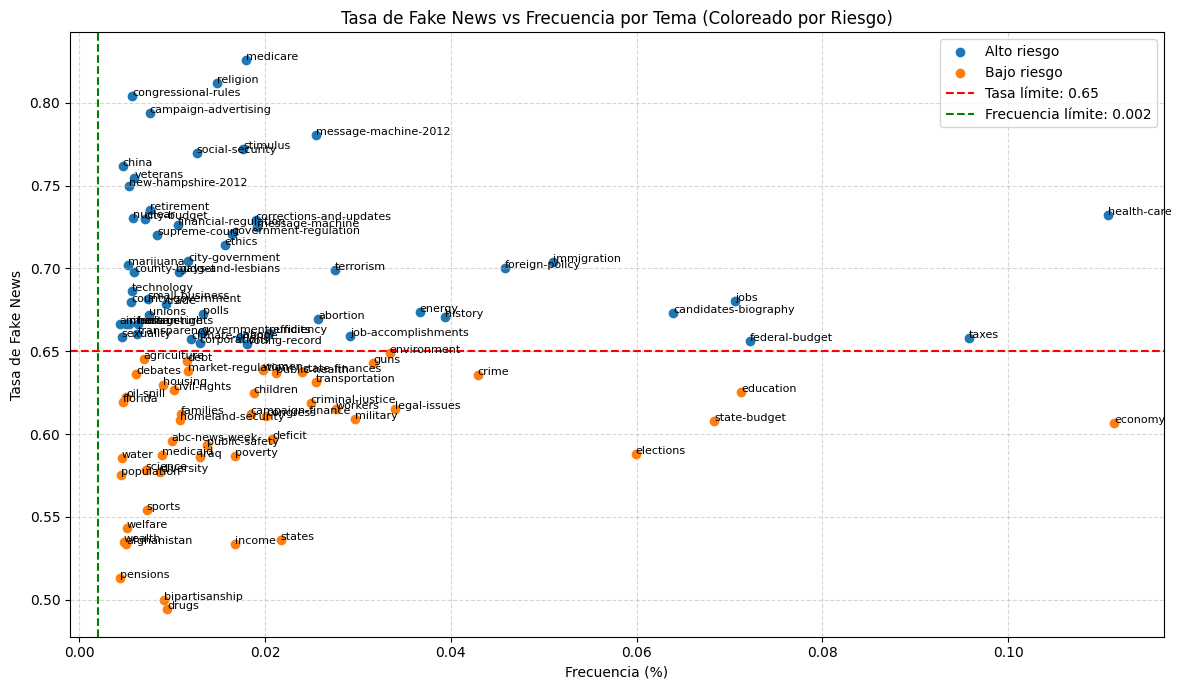

In [13]:
import matplotlib.pyplot as plt

# Clasificar los temas
def classify_topic(row):
    if row["fake_news_rate"] < rate_threshold and row["frequency_pct"] > freq_threshold:
        return "Bajo riesgo"
    else:
        return "Alto riesgo"

topic_fake_df["riesgo"] = topic_fake_df.apply(classify_topic, axis=1)

# Graficar
plt.figure(figsize=(12, 7))

for riesgo, subset in topic_fake_df.groupby("riesgo"):
    plt.scatter(subset["frequency_pct"], subset["fake_news_rate"], label=riesgo)

    for topic, row in subset.iterrows():
        plt.text(row["frequency_pct"], row["fake_news_rate"], topic, fontsize=8)

# Líneas de umbral
plt.axhline(rate_threshold, color='red', linestyle='--', label=f"Tasa límite: {rate_threshold}")
plt.axvline(freq_threshold, color='green', linestyle='--', label=f"Frecuencia límite: {freq_threshold}")

# Estilo
plt.title("Tasa de Fake News vs Frecuencia por Tema (Coloreado por Riesgo)")
plt.xlabel("Frecuencia (%)")
plt.ylabel("Tasa de Fake News")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



`high_risk_topic`

In [14]:
rate_threshold = 0.70
freq_threshold = 0.001
# Seleccionar temas de alto riesgo
high_risk_topics = topic_fake_df[
    (topic_fake_df["fake_news_rate"]> rate_threshold) & 
    (topic_fake_df["frequency_pct"] > freq_threshold)
].index.tolist()

# Crear la nueva columna binaria
df["has_high_risk_topic"] = df[high_risk_topics].any(axis=1).astype(int)
# Ver distribución y fake news rate
high_risk_top = df.groupby("has_high_risk_topic")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()
high_risk_top

,has_high_risk_topic,count,fake_news_rate
0,0,5903,0.605455
1,1,3047,0.728914


Y observamos la distribución para establecer los umbrales

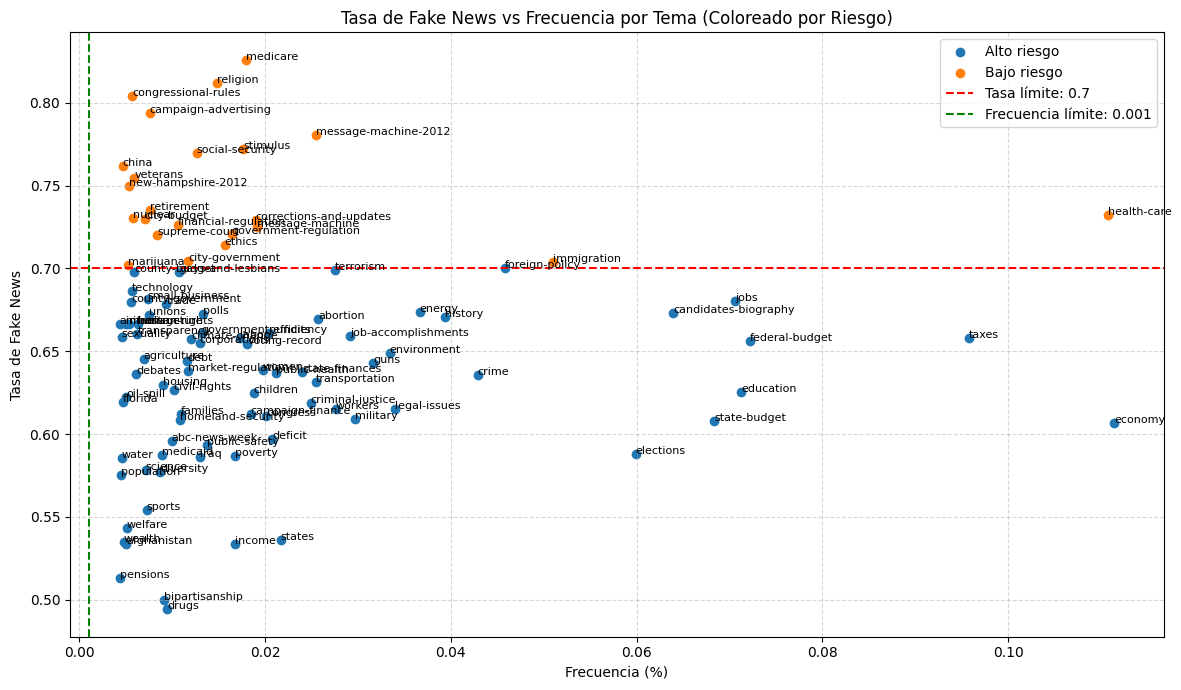

In [15]:
import matplotlib.pyplot as plt

# Clasificar los temas
def classify_topic(row):
    if row["fake_news_rate"] > rate_threshold and row["frequency_pct"] > freq_threshold:
        return "Bajo riesgo"
    else:
        return "Alto riesgo"

topic_fake_df["riesgo"] = topic_fake_df.apply(classify_topic, axis=1)

# Graficar
plt.figure(figsize=(12, 7))

for riesgo, subset in topic_fake_df.groupby("riesgo"):
    plt.scatter(subset["frequency_pct"], subset["fake_news_rate"], label=riesgo)

    for topic, row in subset.iterrows():
        plt.text(row["frequency_pct"], row["fake_news_rate"], topic, fontsize=8)

# Líneas de umbral
plt.axhline(rate_threshold, color='red', linestyle='--', label=f"Tasa límite: {rate_threshold}")
plt.axvline(freq_threshold, color='green', linestyle='--', label=f"Frecuencia límite: {freq_threshold}")

# Estilo
plt.title("Tasa de Fake News vs Frecuencia por Tema (Coloreado por Riesgo)")
plt.xlabel("Frecuencia (%)")
plt.ylabel("Tasa de Fake News")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
# Contar la distribución de clases
label_counts = df['label'].value_counts().sort_index()

# Imprimir distribución
print("Distribución de la clase objetivo:")
print(label_counts)
print("\nProporciones:")
print((label_counts / label_counts.sum()).round(3))

Distribución de la clase objetivo:
label
0.0    3155
1.0    5795
Name: count, dtype: int64

Proporciones:
label
0.0    0.353
1.0    0.647
Name: count, dtype: float64


El dataset está desbalanceado, por lo que se usará como primera aproximación en CatBoost el parámetro `auto_class_weights = 'Balanced' `

## Modelo CatBoost Simple

### Evaluación

In [17]:
# Definir la columna objetivo
X = df.copy().drop(columns=['label'])
X = X.drop(columns=drop_cols)
state_cols = [col for col in df.columns if col.startswith("state_info_")]
X = X.drop(columns=state_cols)
y = df_label

# Detectar columnas categóricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['party_affiliation_uni', 'speaker_job_grouped']

In [18]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inicializar y entrenar el modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=8,
    cat_features=cat_features,
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)
model.fit(X_train, y_train)

0:	learn: 0.6917379	total: 88.9ms	remaining: 44.4s
100:	learn: 0.6474583	total: 1.75s	remaining: 6.91s
200:	learn: 0.6305175	total: 3.04s	remaining: 4.52s
300:	learn: 0.6137670	total: 4.3s	remaining: 2.84s
400:	learn: 0.5939018	total: 5.65s	remaining: 1.4s
499:	learn: 0.5756068	total: 6.96s	remaining: 0us


In [19]:
# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5737430167597766
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.61      0.50       631
           1       0.72      0.55      0.63      1159

    accuracy                           0.57      1790
   macro avg       0.57      0.58      0.56      1790
weighted avg       0.62      0.57      0.58      1790



### Importancia de categorías

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener importancia
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 más importantes
print(importance_df.head(20))

                    Feature  Importance
0     party_affiliation_uni   18.540062
101     speaker_job_grouped   14.440512
130     has_high_risk_topic    7.189118
129      has_low_risk_topic    3.791459
6                      jobs    2.620144
117  speaker_job_non-define    2.561135
127    speaker_job_low_risk    2.495666
2               health-care    2.202414
1                   economy    2.017944
4            federal-budget    1.957127
3                     taxes    1.815944
126     has_non_define_info    1.480615
8      candidates-biography    1.362144
13                  history    1.351893
11           foreign-policy    1.340815
16              environment    1.164165
45                 religion    1.041245
28            public-health    0.942234
38                 medicare    0.910901
27                   states    0.896995


### Estados de bajo/alto riesgo

Se sigue la misma lógica descrita anteriormente para detectar estados de alto/bajo riesgo:

In [21]:
# Filtrar columnas de estados
state_cols = [col for col in df.columns if col.startswith("state_info_")]

# Calcular fake rate y frecuencia
state_stats = {}
for col in state_cols:
    mask = df[col] == 1
    state_stats[col] = {
        "fake_news_rate": df[mask]["label"].mean(),
        "frequency": mask.sum(),
        "frequency_pct": mask.sum() / len(df)
    }

# Convertir a DataFrame
state_df = pd.DataFrame.from_dict(state_stats, orient="index")

# Definir umbrales
low_fake_threshold = 0.8
min_freq_threshold = 0.01

# Seleccionar estados de bajo riesgo
low_risk_states = state_df[
    (state_df["fake_news_rate"] < low_fake_threshold) &
    (state_df["frequency_pct"] > min_freq_threshold)
].index.tolist()

# Crear variable binaria
df["state_low_risk"] = df[low_risk_states].any(axis=1).astype(int)

# Verificación
print("Estados seleccionados como bajo riesgo:", low_risk_states)
print(df["state_low_risk"].value_counts())
print(df.groupby("state_low_risk")["label"].mean())

df = df.drop(columns=state_cols)

Estados seleccionados como bajo riesgo: ['state_info_arizona', 'state_info_california', 'state_info_florida', 'state_info_georgia', 'state_info_illinois', 'state_info_massachusetts', 'state_info_new_jersey', 'state_info_new_york', 'state_info_non-define', 'state_info_ohio', 'state_info_oregon', 'state_info_rhode_island', 'state_info_texas', 'state_info_virginia', 'state_info_washington_dc', 'state_info_wisconsin']
state_low_risk
1    7868
0    1082
Name: count, dtype: int64
state_low_risk
0    0.646026
1    0.647687
Name: label, dtype: float64


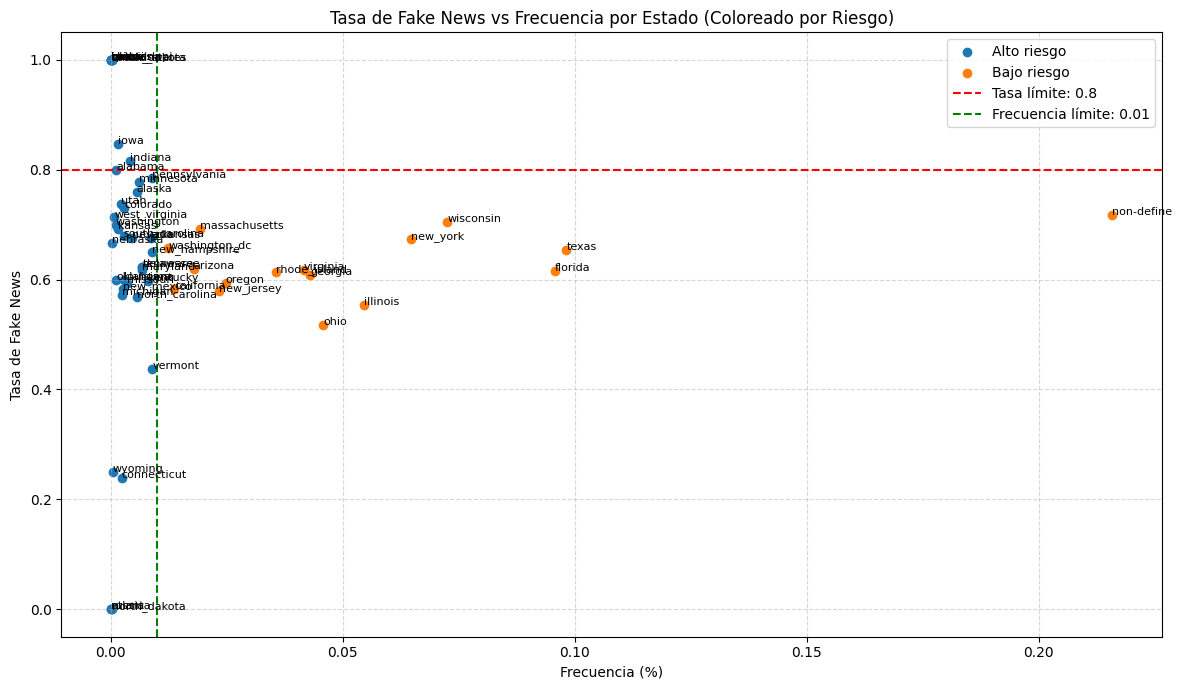

In [22]:
import matplotlib.pyplot as plt

# Clasificar estados según thresholds
def classify_state(row):
    if row["fake_news_rate"] < low_fake_threshold and row["frequency_pct"] > min_freq_threshold:
        return "Bajo riesgo"
    else:
        return "Alto riesgo"

state_df["riesgo"] = state_df.apply(classify_state, axis=1)

# Graficar
plt.figure(figsize=(12, 7))

for riesgo, subset in state_df.groupby("riesgo"):
    plt.scatter(subset["frequency_pct"], subset["fake_news_rate"], label=riesgo)

    for state, row in subset.iterrows():
        label = state.replace("state_info_", "")  # limpiar nombre
        plt.text(row["frequency_pct"], row["fake_news_rate"], label, fontsize=8)

# Líneas de umbral
plt.axhline(low_fake_threshold, color='red', linestyle='--', label=f"Tasa límite: {low_fake_threshold}")
plt.axvline(min_freq_threshold, color='green', linestyle='--', label=f"Frecuencia límite: {min_freq_threshold}")

# Estilo
plt.title("Tasa de Fake News vs Frecuencia por Estado (Coloreado por Riesgo)")
plt.xlabel("Frecuencia (%)")
plt.ylabel("Tasa de Fake News")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [23]:
df["low_risk"] = (
    (df["has_low_risk_topic"] == 1) | 
    (df["speaker_job_low_risk"] == 1)
).astype(int)

# Ver distribución y fake news rate
non_define_summary = df.groupby("low_risk")["label"].agg(
    count="count", fake_news_rate="mean"
).reset_index()

# Mostrar resumen
print("Distribución de has_non_define_info:")
print(df["low_risk"].value_counts())
print("\nFake rate por grupo:")
print(non_define_summary)

Distribución de has_non_define_info:
low_risk
1    7234
0    1716
Name: count, dtype: int64

Fake rate por grupo:
   low_risk  count  fake_news_rate
0         0   1716        0.747669
1         1   7234        0.623721


In [24]:
X.head(5)

,party_affiliation_uni,economy,health-care,taxes,federal-budget,education,jobs,state-budget,candidates-biography,elections,...,speaker_job_speaker of the house of representatives,speaker_job_u.s. congressman,speaker_job_u.s. house of representatives,"speaker_job_u.s. representative, florida district 23",speaker_job_u.s. senator from ohio,has_non_define_info,speaker_job_low_risk,speaker_job_high_risk,has_low_risk_topic,has_high_risk_topic
0,republican,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,0,0,1,1,1
1,democrat,0,1,0,0,0,0,0,0,0,...,False,False,False,False,False,0,1,0,0,1
2,democrat,0,0,1,0,0,0,0,0,0,...,False,False,False,False,False,0,1,0,1,0
3,none,0,0,0,0,0,0,0,1,0,...,False,False,False,False,False,1,0,0,1,1
4,republican,0,1,0,0,0,0,1,0,0,...,False,False,False,False,False,1,0,0,1,1


In [25]:
# Entrenamos el mismo modelo que antes
# Definir la columna objetivo
target = 'label'
topic_cols.append(target)
X = df.drop(columns=target)
y = df[target]

# Detectar columnas categóricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [26]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inicializar y entrenar el modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

0:	learn: 0.6891360	total: 17ms	remaining: 8.47s
100:	learn: 0.6246875	total: 1.84s	remaining: 7.28s
200:	learn: 0.5860740	total: 3.49s	remaining: 5.2s
300:	learn: 0.5550835	total: 5.38s	remaining: 3.55s
400:	learn: 0.5288827	total: 7.42s	remaining: 1.83s
499:	learn: 0.5055921	total: 9.38s	remaining: 0us
Accuracy: 0.5832402234636872
Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.60      0.50       631
         1.0       0.72      0.58      0.64      1159

    accuracy                           0.58      1790
   macro avg       0.58      0.59      0.57      1790
weighted avg       0.62      0.58      0.59      1790



La puntuación sube respecto a iteraciones anteriores, pero no es el mejor resultado

In [27]:
# Obtener importancia
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Crear DataFrame ordenado
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 más importantes
print(importance_df.head(50))

                                Feature  Importance
3                               speaker   12.101311
107                 speaker_job_grouped   11.211924
2                               subject   10.647872
5                 party_affiliation_uni    6.271701
4                     party_affiliation    5.605488
6        party_affiliation_category_map    3.722780
143                 has_high_risk_topic    3.622656
142                  has_low_risk_topic    1.813729
12                                 jobs    1.764944
8                           health-care    1.434840
9                                 taxes    1.230663
10                       federal-budget    1.088874
7                               economy    0.980321
20                               energy    0.944666
44                             medicare    0.902875
33                               states    0.896286
45                             stimulus    0.854339
14                 candidates-biography    0.842968
17          

F1 score macro avg ha bajado un 2% al usar el **top20** y se mantiene al usar el **top50**. Usar las 50 más im0portantes genera el mismo rendimiento, pero resta complejidad al modelo y reduce el tiempo de entrenamiento. Se procede a comenzar con tunning para ver hasta cuánto puede llegar el estimador empleado, mejorando sus hiperparámetros. Comenzamos con búsqueda aleatoria y un amplio rango de hiperparámetros. 

In [28]:
# Filtramos las más relevantes
top_n = 15
top_features = importance_df['Feature'].head(top_n).tolist()

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
cat_features_top = X_train_top.select_dtypes(include=['object']).columns.tolist()
# Reentrenamos el modelo
model_top = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    cat_features=cat_features_top,
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)
model_top.fit(X_train_top, y_train)

# Evaluar el modelo
y_pred_top = model_top.predict(X_test_top)
print("Accuracy:", accuracy_score(y_test, y_pred_top))
print("Classification Report:\n", classification_report(y_test, y_pred_top))

0:	learn: 0.6902970	total: 19.2ms	remaining: 19.2s
100:	learn: 0.6276046	total: 1.57s	remaining: 13.9s
200:	learn: 0.5955187	total: 3.89s	remaining: 15.5s
300:	learn: 0.5596867	total: 5.79s	remaining: 13.4s
400:	learn: 0.5271526	total: 7.61s	remaining: 11.4s
500:	learn: 0.5055601	total: 9.36s	remaining: 9.32s
600:	learn: 0.4836291	total: 11.2s	remaining: 7.46s
700:	learn: 0.4636444	total: 12.7s	remaining: 5.41s
800:	learn: 0.4441358	total: 14.1s	remaining: 3.51s
900:	learn: 0.4264157	total: 15.6s	remaining: 1.71s
999:	learn: 0.4101295	total: 17s	remaining: 0us
Accuracy: 0.5826815642458101
Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.53      0.47       631
         1.0       0.70      0.61      0.65      1159

    accuracy                           0.58      1790
   macro avg       0.57      0.57      0.56      1790
weighted avg       0.61      0.58      0.59      1790



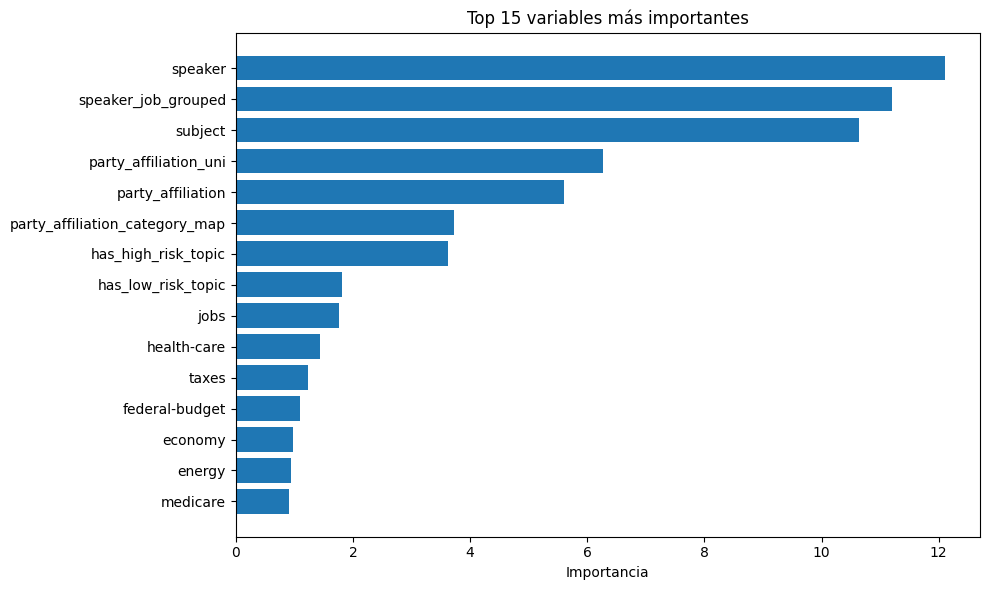

In [29]:
# Visualizar las top
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])
plt.xlabel('Importancia')
plt.title(f'Top {top_n} variables más importantes')
plt.tight_layout()
plt.show()

In [30]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Modelo base
base_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=100,
    random_state=42
)

# Hiperparámetros a explorar
param_dist = {
    'iterations': [200, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5],
}

# Búsqueda aleatoria
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [31]:
# Iniciamos la busqueda
search.fit(X_train_top, y_train, cat_features=cat_features_top)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 0.6927390	total: 11.6ms	remaining: 8.13s
100:	learn: 0.6713272	total: 610ms	remaining: 3.62s
200:	learn: 0.6641328	total: 1.78s	remaining: 4.41s
300:	learn: 0.6605090	total: 2.37s	remaining: 3.14s
400:	learn: 0.6580618	total: 2.98s	remaining: 2.22s
500:	learn: 0.6561993	total: 3.6s	remaining: 1.43s
600:	learn: 0.6546254	total: 4.32s	remaining: 711ms
699:	learn: 0.6531066	total: 4.96s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x127783cd0>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8],
                                        'iterations': [200, 500, 700],
                                        'l2_leaf_reg': [3, 5],
                                        'learning_rate': [0.01, 0.03, 0.05]},
                   scoring='f1_macro', verbose=2)

In [32]:
# Evaluación final en test
best_model = search.best_estimator_
y_pred = best_model.predict(X_test_top)
print("Best Params:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Params: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 4}
Accuracy: 0.5748603351955307
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.70      0.54       631
         1.0       0.76      0.51      0.61      1159

    accuracy                           0.57      1790
   macro avg       0.60      0.60      0.57      1790
weighted avg       0.64      0.57      0.58      1790



El resultado baja un 1% conforme al primero obtenido. 

In [38]:
import numpy as np
# Paso 1: Obtener probabilidades del modelo entrenado
y_probs = best_model.predict_proba(X_test_top)[:, 1]  # Clase 1

# Paso 2: Buscar el mejor umbral
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    score = f1_score(y_test, y_pred_thresh, average='macro')
    f1_scores.append(score)

# Paso 3: Obtener mejor umbral
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Paso 4: Evaluar con el umbral óptimo
y_pred_opt = (y_probs >= best_threshold).astype(int)

print(f"🔎 Mejor umbral: {best_threshold:.2f} con F1 macro: {best_f1:.4f}")
print("Best Params:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("Classification Report:\n", classification_report(y_test, y_pred_opt))

🔎 Mejor umbral: 0.44 con F1 macro: 0.5972
Best Params: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 4}
Accuracy: 0.6441340782122905
Classification Report:
               precision    recall  f1-score   support

         0.0       0.49      0.43      0.46       631
         1.0       0.71      0.76      0.73      1159

    accuracy                           0.64      1790
   macro avg       0.60      0.60      0.60      1790
weighted avg       0.63      0.64      0.64      1790



In [39]:
# Dividir internamente para validación del early stopping
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_top, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [40]:
from catboost import Pool

# Pools de CatBoost para usar eval_set
train_pool = Pool(X_train_main, y_train_main, cat_features=cat_features_top)
val_pool = Pool(X_val, y_val, cat_features=cat_features_top)


In [41]:
# Tomar los mejores hiperparámetros encontrados
best_params = search.best_params_
best_params.update({
    'auto_class_weights': 'Balanced',
    'early_stopping_rounds': 50,
    'verbose': 100,
    'random_state': 42
})

# Entrenar modelo final
final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=val_pool)

# Evaluar en conjunto de test final
y_pred_final = final_model.predict(X_test_top)
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final))

0:	learn: 0.6927590	test: 0.6927652	best: 0.6927652 (0)	total: 11.9ms	remaining: 8.29s
100:	learn: 0.6716699	test: 0.6749744	best: 0.6749744 (100)	total: 1.29s	remaining: 7.64s
200:	learn: 0.6638928	test: 0.6701055	best: 0.6701031 (199)	total: 1.92s	remaining: 4.77s
300:	learn: 0.6600205	test: 0.6684638	best: 0.6684638 (300)	total: 2.51s	remaining: 3.32s
400:	learn: 0.6572504	test: 0.6676661	best: 0.6676442 (398)	total: 3.05s	remaining: 2.27s
500:	learn: 0.6551658	test: 0.6673124	best: 0.6672542 (466)	total: 3.56s	remaining: 1.41s
600:	learn: 0.6530231	test: 0.6668312	best: 0.6668260 (595)	total: 4.31s	remaining: 710ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.666747377
bestIteration = 614

Shrink model to first 615 iterations.
Accuracy: 0.5865921787709497
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.65      0.53       631
         1.0       0.74      0.55      0.63      1159

    accuracy       

Resultado óptimo: **58%**

# Generar CSV de resultados con el modelo final

In [42]:
# Cargar los datos de test
df_test = pd.read_csv("../../data/processed/test_simp_preprocess_v1.csv")
df_test.columns.size

215

In [43]:
import datetime
import pandas as pd
from catboost import Pool

# === 1. Guardar los IDs y limpiar
test_ids = df_test["id"]
df_test = df_test.drop(columns=["id"], errors="ignore")

# === 2. Asegurar que test tenga todas las columnas necesarias
missing_cols = set(top_features) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0  # Rellenar columnas faltantes con 0

# Avisar si faltan columnas por transparencia
if missing_cols:
    print(f"Columnas faltantes añadidas en test: {missing_cols}")

Columnas faltantes añadidas en test: {'has_low_risk_topic', 'party_affiliation', 'has_high_risk_topic'}


In [44]:
# Seleccionar solo las columnas válidas y en el orden correcto
#df_test = df_test.drop(columns=drop_cols)
top_features_valid = [col for col in top_features if col in df_test.columns]
df_test = df_test[top_features_valid]

# Detectar columnas categóricas por nombre e índice
cat_feature_names = [col for col in cat_features_top if col in df_test.columns]
cat_feature_indices = [df_test.columns.get_loc(col) for col in cat_feature_names]

# Crear Pool y predecir
test_pool = Pool(df_test, cat_features=cat_feature_indices)
y_pred_test = final_model.predict(test_pool)

# Guardar predicciones
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output = pd.DataFrame({
    "id": test_ids,
    "label": y_pred_test.astype(int)
})
filename = f"../3_summision/CatBoost_simp_{current_date}.csv"
output.to_csv(filename, index=False)
print(f"Predicciones guardadas en {filename}")

Predicciones guardadas en ../3_summision/CatBoost_simp_2025-05-20_21-51-55.csv


## Conclusión
El pipeline desarrollado en este notebook logra un rendimiento inicial del 56.30% en F1-score promedio, lo que representa un punto de partida razonable considerando la complejidad del problema y el desbalance entre clases. La estrategia de ingeniería de características muestra valor al capturar relaciones no triviales entre atributos, mientras que el uso de CatBoost permite aprovechar estas relaciones sin requerir transformaciones excesivas.